In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')

import numpy as np
import pandas as pd
from spykes.neurovis import NeuroVis

# Reproduce a figure from a published article with a public dataset

### This article:
 Ramkumar, Pavan, et al. "Premotor and Motor Cortices Encode Reward." PloS one 11.8 (2016): e0160851. [[link to paper](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0160851)]



### Here's Figure 2:

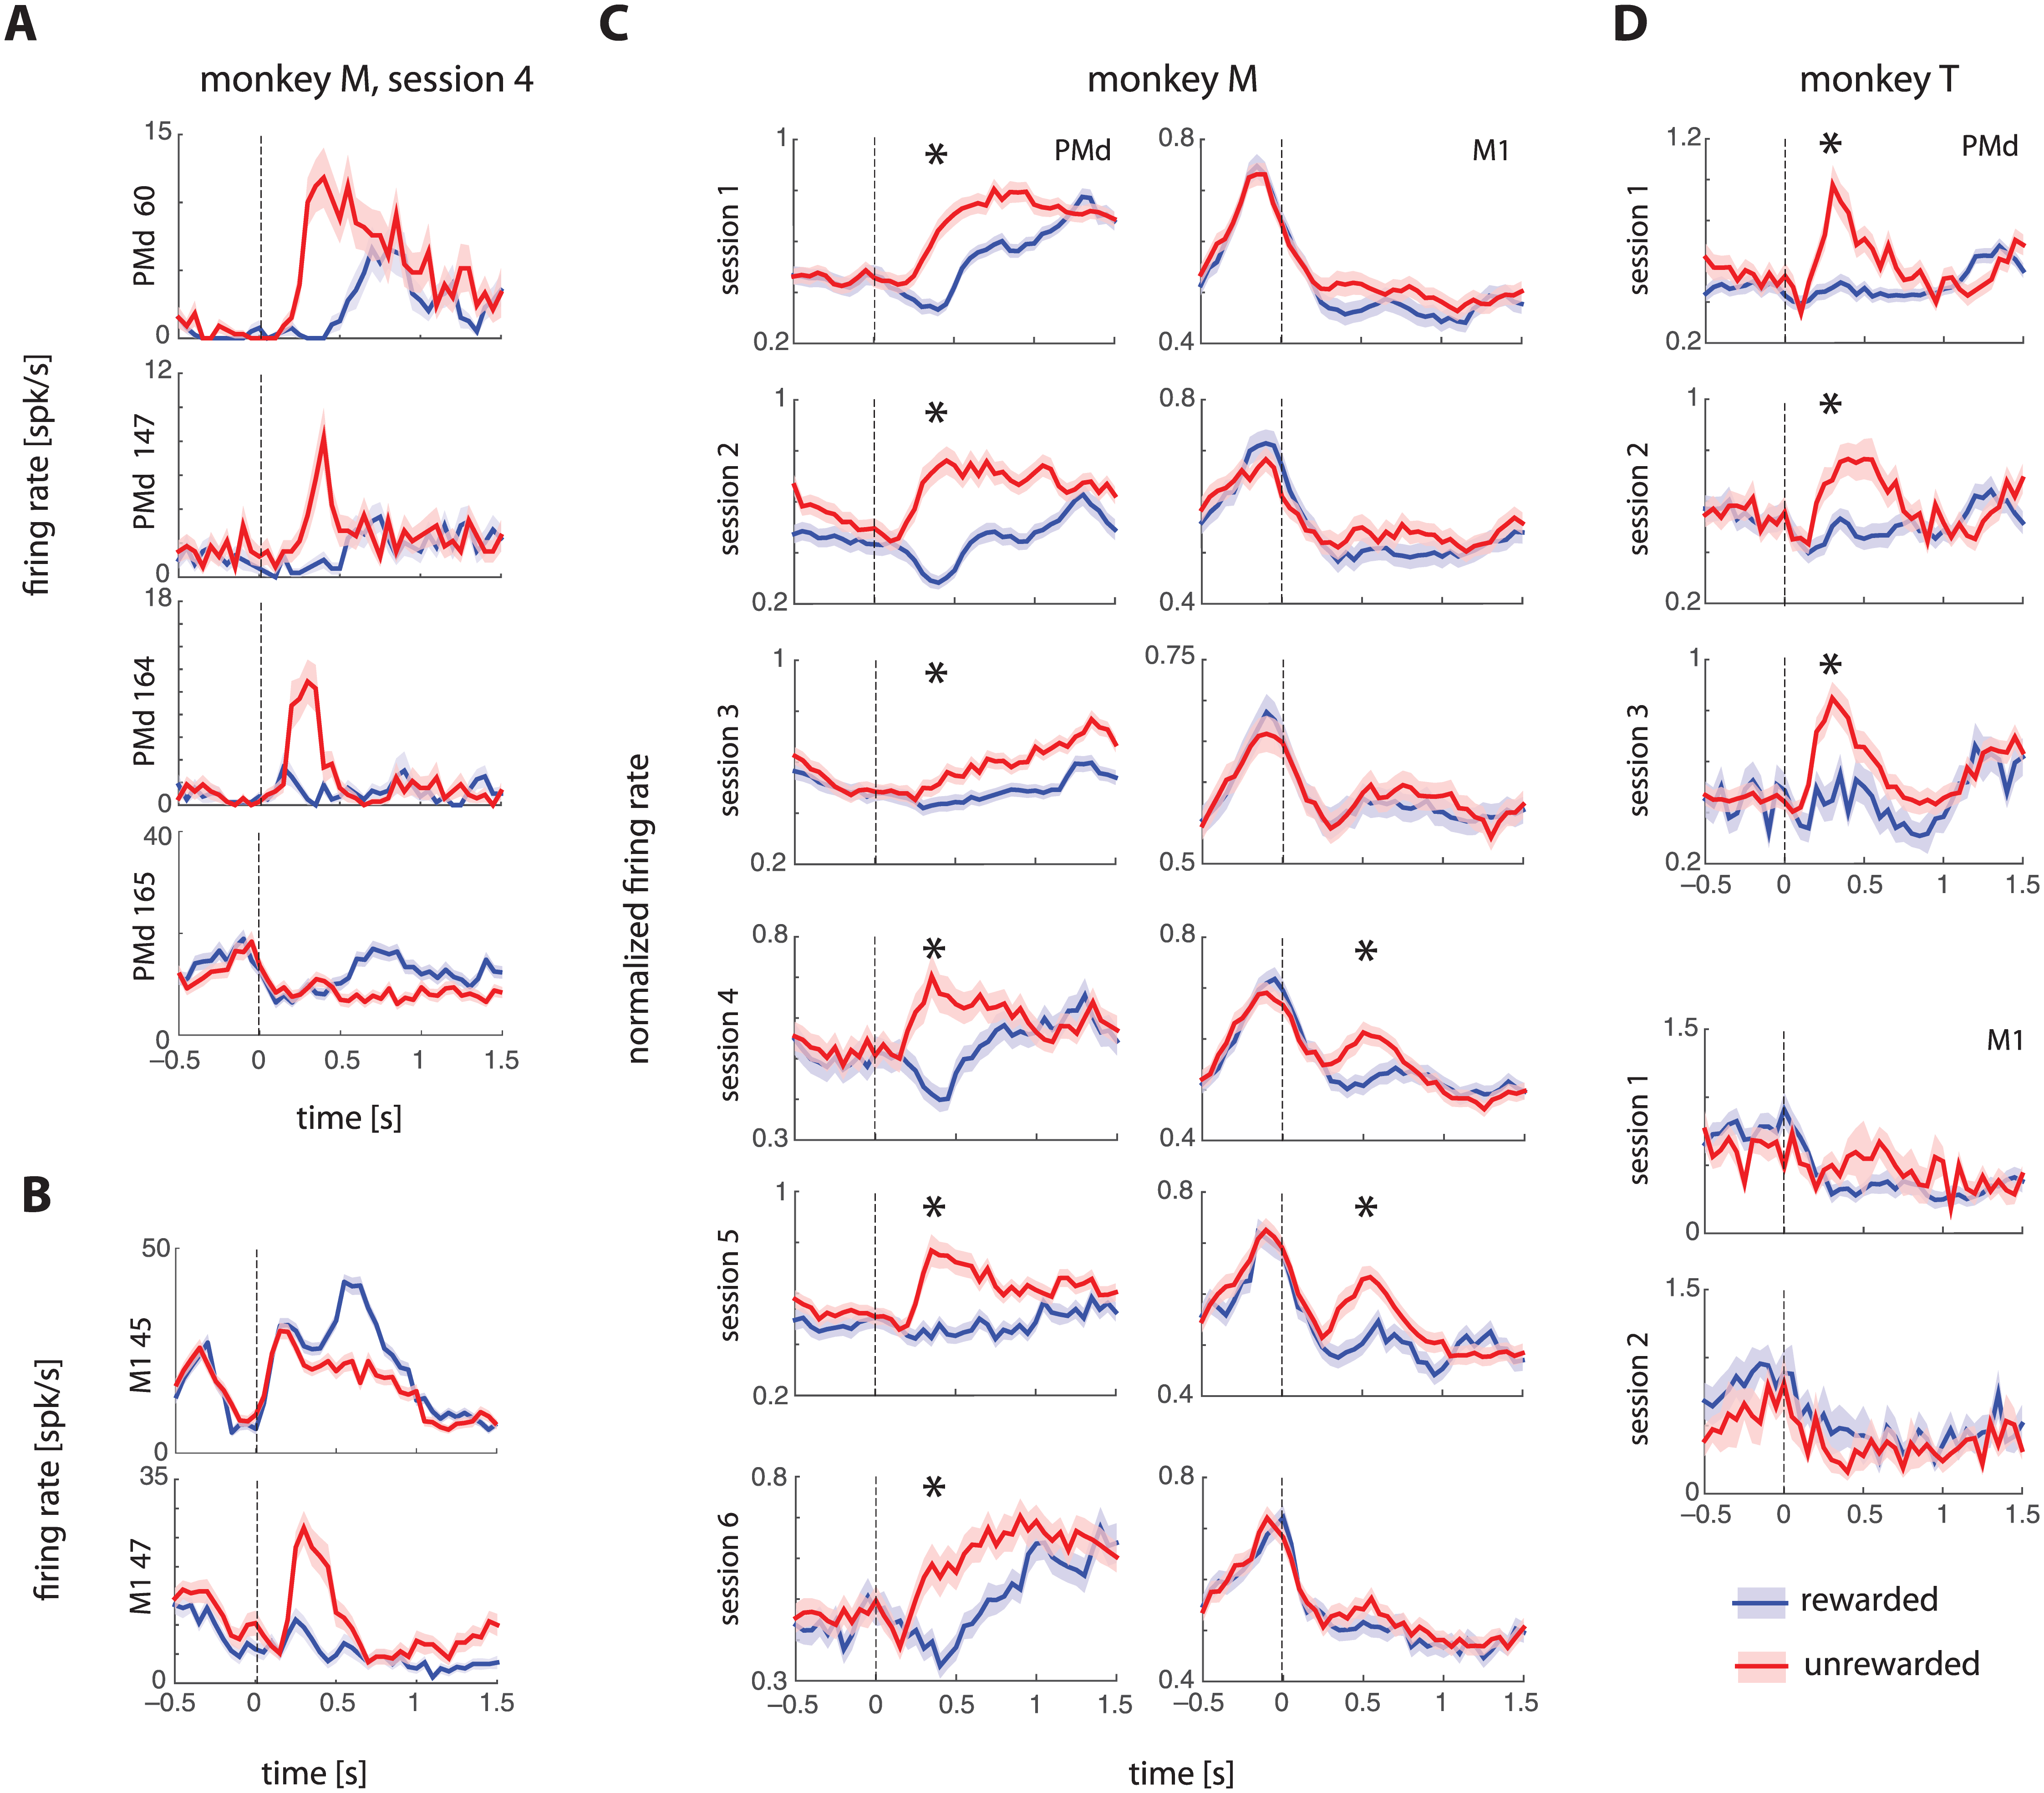

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(filename="./figures/journal.pone.0160851.g002.PNG", width=650)

# Let's reproduce all panels

## 0.1 Download data

#### Download all files [[here](https://figshare.com/articles/Ramkumar_et_al_2016_Premotor_and_motor_cortices_encode_reward/3573447)]. However, we'll only be looking at Mihili_07112013.mat (Monkey M, Session 1) and Mihili_08062013.mat (Monkey M, Session 4)  

## 0.2 Initialize Variables

In [3]:
event = 'rewardTime'
condition = 'rewardBool'
window = [-500, 1500]
binsize = 10

## 1. We'll first do the first graph of Panel A
### (The other graphs in A & B are done the same way, just a different neuron number or switching PMd for M1)

In [4]:
import scipy.io
mat = scipy.io.loadmat('3573447/Mihili_08062013.mat')

### 1.1. Initiate all Neurons

In [5]:
def get_spike_time(raw_data, neuron_number):
    
    spike_times = raw_data['alldays'][0]['PMd_units'][0][:][neuron_number-1][0][1:]
    spike_times = [i[0] for i in spike_times]
    
    return spike_times

In [6]:
def initiate_neurons(raw_data):
    
    neuron_list = list()
    
    for i in range((raw_data['alldays'][0]['PMd_units'][0][:]).shape[0]):
        spike_times = get_spike_time(raw_data, i+1)

        # instantiate neuron
        neuron = NeuroVis(spike_times, name = 'PMd %d' % (i+1))
        neuron_list.append(neuron)
        
    return neuron_list

In [7]:
neuron_list = initiate_neurons(mat)

### 1.2. Get event times

In [8]:
def create_data_frame(raw_data):

    data_df = pd.DataFrame()
    
    uncertainty_conditions = list()
    center_target_times = list()
    reward_times = list()
    reward_outcomes = list()
            
    meta_data = raw_data['alldays'][1]['tt'][0]

    uncertainty_conditions.append(meta_data[:,2])
    center_target_times.append(meta_data[:,3])
    reward_times.append(meta_data[:,6])
    reward_outcomes.append(meta_data[:,7])
        
    data_df['uncertaintyCondition'] = np.concatenate(uncertainty_conditions)
    data_df['centerTargetTime'] = np.concatenate(center_target_times)
    data_df['rewardTime'] = np.concatenate(reward_times)
    data_df['rewardOutcome'] = np.concatenate(reward_outcomes)
        
    data_df['rewardBool'] = data_df['rewardOutcome'].map(lambda s: s == 32)
    
    # find time in between previous reward onset and start of current trial
    # shouldn't be more than 1500ms
    
    start_times = data_df['centerTargetTime']
    last_reward_times = np.roll(data_df['rewardTime'], 1)
    
    diffs = start_times - last_reward_times
    diffs[0] = 0
    
    data_df['consecutiveBool'] = diffs.map(lambda s: s <= 1.5)
        
    return data_df[((data_df['uncertaintyCondition'] == 5.0) | (data_df['uncertaintyCondition'] == 50.0)) 
                  & data_df['consecutiveBool']]    
    

In [9]:
data_df = create_data_frame(mat)
print len(data_df)
data_df.head()

322


,uncertaintyCondition,centerTargetTime,rewardTime,rewardOutcome,rewardBool,consecutiveBool
0,5.0,1464.498433,1467.493,34.0,False,True
2,5.0,1481.082633,1483.947,34.0,False,True
6,5.0,1509.540300,1511.946,34.0,False,True
7,5.0,1513.181333,1515.847,32.0,True,True
8,5.0,1516.982767,1519.256,32.0,True,True


### 1.3. Match Peak Velocities
#### (Peak velocities must be in between 11 and 16 cm/s)

In [10]:
def find_velocities_in_range(raw_data, dataframe, min_vel, max_vel, min_time, max_time):  
    
    all_velocities = raw_data['alldays'][0]['kin'][0]['vel'][0][0]

    max_velocities = np.empty(len(dataframe))
    peak_times = np.empty(len(dataframe))

    for i in range(len(dataframe)):
        
        # find time range for potential peak velocity
        start_time = dataframe['rewardTime'][i] + .2
        end_time = dataframe['rewardTime'][i] + 1.5

        # find velocities in the time range
        indices = (all_velocities[:,0] > start_time) & (all_velocities[:,0] < end_time)
        in_time = all_velocities[indices]

        # find max velocity in given time range
        velocity_norms = np.square(in_time[:,1]) + np.square(in_time[:,2])
        
        max_velocity_index = np.argmax(velocity_norms)
        
        max_velocities[i] = velocity_norms[max_velocity_index]**.5
        peak_times[i] = in_time[max_velocity_index,0]
        
    dataframe['maxVelocity'] = max_velocities
    dataframe['peakTimesDiff'] = peak_times - dataframe['rewardTime']
    
    return dataframe[((dataframe['maxVelocity'] >= min_vel) & (dataframe['maxVelocity'] <= max_vel)) & 
                    ((dataframe['peakTimesDiff'] >= min_time) & (dataframe['peakTimesDiff'] <= max_time))]

In [11]:
trials_df = find_velocities_in_range(mat, data_df.reset_index(), 11, 16, .55, .95)
print len(trials_df)
trials_df.head()

112


,index,uncertaintyCondition,centerTargetTime,rewardTime,rewardOutcome,rewardBool,consecutiveBool,maxVelocity,peakTimesDiff
0,0,5.0,1464.498433,1467.493,34.0,False,True,15.949382,0.868
5,9,50.0,1520.391233,1523.123,32.0,True,True,14.863242,0.877
7,12,50.0,1536.132333,1538.917,34.0,False,True,14.925620,0.924
9,14,5.0,1544.061033,1546.955,34.0,False,True,12.985189,0.818
11,16,5.0,1552.524033,1554.978,32.0,True,True,15.723927,0.691


 ### 1.4. Plot PSTH plots

#### PSTH (before matching)

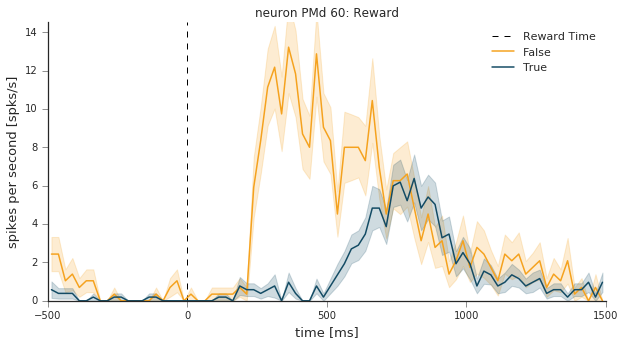

In [12]:
neuron_number = 60
neuron = neuron_list[neuron_number-1]

plt.figure(figsize=(10,5))
psth = neuron.get_psth(event=event,
                           conditions=condition, 
                           df=data_df,
                           window=[-500,1500],
                           binsize=25,
                           event_name='Reward Time');

plt.title('neuron %s: Reward' % neuron.name)
plt.show()

#### PSTH (after velocity matching)

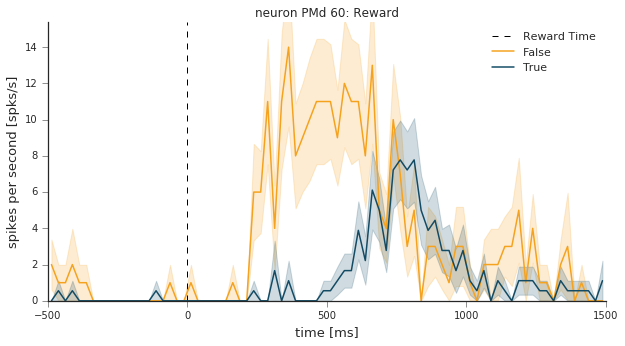

In [13]:
neuron_number = 60
neuron = neuron_list[neuron_number-1]

plt.figure(figsize=(10,5))
psth = neuron.get_psth(event=event,
                           conditions=condition, 
                           df=trials_df,
                           window=[-500,1500],
                           binsize=25,
                           event_name='Reward Time');

plt.title('neuron %s: Reward' % neuron.name)
plt.show()

## 2. We'll now do the first graph of Panel C
### (The other graphs in C & D are done the same way, just a different session number / monkey)

In [14]:
mat = scipy.io.loadmat('3573447/Mihili_07112013.mat')

In [15]:
neuron_list = initiate_neurons(mat)

In [16]:
data_df = create_data_frame(mat)

 ### 2.1. Normalize by setting PSTH's peak to 1

In [17]:
def normalize_psth(neuron, dataframe):
    
    psth = neuron.get_psth(event = event, 
                           conditions = condition, 
                           df = dataframe, 
                           window = window, 
                           binsize = binsize,
                           plot=False);
    
    # find all max rates, and find max of max rates
    
    max_rates = list()
    
    for i, cond_id in enumerate(np.sort(psth['data'].keys())):
        max_rates.append(np.amax(psth['data'][cond_id]['mean']))
        
    max_rate = max(max_rates)
    
    # divide all means by max to normalize
    
    for i, cond_id in enumerate(np.sort(psth['data'].keys())):
        
        psth['data'][cond_id]['mean'] /= max_rate
        psth['data'][cond_id]['sem'] = 0 # population SEM calculated later
        
    return psth

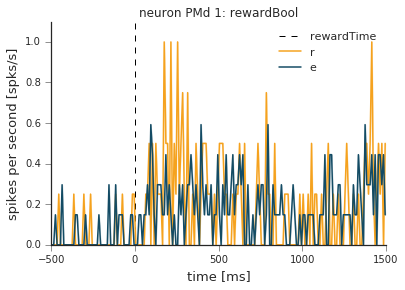

In [18]:
neuron = neuron_list[0] # example

new_psth = normalize_psth(neuron, data_df)

neuron.plot_psth(new_psth, event, condition)

 ### 2.2. Find Population Average

In [19]:
psth_dict = {}
for cond_id in np.sort(psth['data'].keys()):
    psth_dict[cond_id] = list()


# add all normalized psth's
for neuron in neuron_list:
    
    norm_psth = normalize_psth(neuron, data_df)
    
    for cond_id in np.sort(psth['data'].keys()):
        psth_dict[cond_id].append(norm_psth['data'][cond_id]['mean'])
        
for key in psth_dict:
    psth_dict[key] = np.array(psth_dict[key])

# get base psth

base_neuron = neuron_list[0]
psth = normalize_psth(base_neuron, data_df)

# update mean and SEM to reflect population
        
for cond_id in np.sort(psth['data'].keys()):
    
    psth['data'][cond_id]['mean'] = np.mean(psth_dict[cond_id], axis=0)
    psth['data'][cond_id]['sem'] = (np.var(psth_dict[cond_id], axis=0) / len(neuron_list))**.5
    

 ### 2.3. Plot PSTH

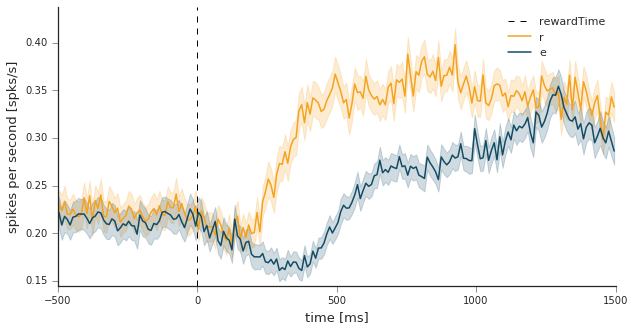

In [20]:
plt.figure(figsize=(10,5))
neuron.plot_psth(psth, event, condition)
plt.title("")
plt.show() 